In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import json
import matplotlib as mpl
from scipy import stats
import seaborn as sns
import math

In [2]:
base = "/scratch/local/ssd/bella/msc-project/results/experiment_noise_tolerance"

In [3]:
def load_results(base):
    activations_dfs = []
    success_rate_dfs = []
    experiment_base = f"{base}/experiment_runs"
    for entry in os.listdir(experiment_base):
        entry_path = Path(os.path.join(experiment_base, entry))
        
        if entry_path.is_dir():
            experiment_name = entry_path.name
            activations_path = os.path.join(entry_path, "activations.pkl")
            success_rate_path = os.path.join(entry_path, "results.json")

            activations_df = pd.read_pickle(activations_path)
            success_rate_str = open(success_rate_path, "r").read()
            success_rate_json = json.loads(success_rate_str)
            success_rate_list = [[experiment_name, round(float(std),3), success_rate] for (std, success_rate) in success_rate_json.items()]
            success_rate_df = pd.DataFrame(success_rate_list, columns=["Model", "Std", "Success Rate"])

            activations_df["model"] = experiment_name

            activations_dfs.append(activations_df)
            success_rate_dfs.append(success_rate_df)

    activations = pd.concat(activations_dfs, axis=0)
    success_rates = pd.concat(success_rate_dfs, axis=0)

    return activations, success_rates

In [4]:
activations_df, success_rate_df = load_results(base)

In [5]:
activations_df["model"].unique()

array(['baseline', 'baseline_majority_vote_5', 'baseline_majority_vote_7',
       'robust_xor', 'robust_xor_majority_vote_3',
       'robust_xor_majority_vote_5', 'robust_xor_majority_vote_7',
       'triple', 'baseline_majority_vote_3', 'baseline_majority_vote_15',
       'multiplexed_xor_5_lines', 'multiplexed_xor_3_lines'], dtype=object)

In [35]:
activations_df, success_rate_df = activations_df[activations_df["model"].isin(['baseline', 'baseline_majority_vote_5', 'baseline_majority_vote_7',
       'robust_xor', 'robust_xor_majority_vote_3',
       'robust_xor_majority_vote_5', 'robust_xor_majority_vote_7',
       'baseline_majority_vote_3',
       'multiplexed_xor_5_lines', 'multiplexed_xor_3_lines'])], success_rate_df[success_rate_df["Model"].isin(['baseline', 'baseline_majority_vote_5', 'baseline_majority_vote_7',
       'robust_xor', 'robust_xor_majority_vote_3',
       'robust_xor_majority_vote_5', 'robust_xor_majority_vote_7',
       'baseline_majority_vote_3', 
       'multiplexed_xor_5_lines', 'multiplexed_xor_3_lines'])]

In [36]:
def compute_activation_diffs(df: pd.DataFrame) -> pd.DataFrame:
    
    def calc_diff_from_baseline(group):
        """For each group (model,layer_idx), compute differences from baseline."""
        
        # Find baseline row
        baseline = group[group['std'] == 0.0]
        
        if len(baseline) == 0:
            return pd.DataFrame()  # No baseline for this group
        
        baseline = baseline.iloc[0]
        baseline_pre = baseline['pre_activations']
        baseline_post = baseline['post_activations']
        
        # Compute differences for all noisy rows
        noisy = group[group['std'] > 0.0].copy()
        
        noisy['pre_diff'] = noisy['pre_activations'].apply(lambda x: np.abs(x - baseline_pre))
        noisy['post_diff'] = noisy['post_activations'].apply(lambda x: np.abs(x - baseline_post))
        
        # Add summary statistics
        noisy['pre_mae'] = noisy['pre_diff'].apply(np.mean)
        noisy['post_ber'] = noisy['post_diff'].apply(np.mean)
        
        return noisy
    
    result = df.groupby(['model','layer_idx'], group_keys=False).apply(calc_diff_from_baseline)
    
    return result.reset_index(drop=True)

In [37]:
activation_errors = compute_activation_diffs(activations_df)

/tmp/ipykernel_48749/58243108.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['model','layer_idx'], group_keys=False).apply(calc_diff_from_baseline)


In [38]:
activation_errors

,layer_idx,sample_idx,pre_activations,post_activations,std,model,pre_diff,post_diff,pre_mae,post_ber
0,0,0,"[0.9950787360201984, 2.004565010519006, 1.0013...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001,baseline,"[0.004921263979801638, 0.004565010519006041, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002692,0.000000
1,0,1,"[1.0040749124135788, 1.9985840497560474, 0.997...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001,baseline,"[0.004074912413578824, 0.0014159502439525795, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002798,0.000000
2,0,2,"[0.9988481398270432, 2.0017894684418724, 1.004...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001,baseline,"[0.0011518601729567646, 0.0017894684418724438,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002720,0.000000
3,0,3,"[1.0022716978581097, 1.9993865053080788, 0.999...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001,baseline,"[0.002271697858109656, 0.0006134946919211792, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002690,0.000000
4,0,4,"[1.000324885382532, 2.0016730554327906, 0.9996...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001,baseline,"[0.00032488538253194754, 0.0016730554327906155...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002717,0.000000
...,...,...,...,...,...,...,...,...,...,...
775995,108,45,"[-0.1481260472177622, 0.03967355739616646, -0....","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.020,robust_xor_majority_vote_7,"[1.1481260472177621, 3.0396735573961666, 4.202...","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",4.771454,0.636364
775996,108,46,"[0.016259849400130186, -0.003169136604074023, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.020,robust_xor_majority_vote_7,"[0.9837401505998699, 2.996830863395926, 3.9769...","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",4.877131,0.545455
775997,108,47,"[1.0645728727526789, -2.0136301814640762, 0.75...","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",0.020,robust_xor_majority_vote_7,"[0.06457287275267887, 0.9863698185359238, 3.24...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",3.233188,0.545455
775998,108,48,"[0.19935347293497233, 0.31062634872346206, 0.0...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.020,robust_xor_majority_vote_7,"[0.8006465270650277, 3.310626348723462, 3.9717...","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",5.060097,0.545455


In [39]:
df = success_rate_df.copy()

In [40]:
df["successes"] = np.round(df['Success Rate'] * 50).astype(int)

In [41]:
df

,Model,Std,Success Rate,successes
0,baseline,0.001,1.0,50
1,baseline,0.002,1.0,50
2,baseline,0.003,1.0,50
3,baseline,0.004,1.0,50
4,baseline,0.005,1.0,50
...,...,...,...,...
15,multiplexed_xor_3_lines,0.016,0.0,0
16,multiplexed_xor_3_lines,0.017,0.0,0
17,multiplexed_xor_3_lines,0.018,0.0,0
18,multiplexed_xor_3_lines,0.019,0.0,0


In [42]:
def compute_confidence_intervals(df, n_trials = 50, confidence=0.95, method="wilson") -> pd.DataFrame:
    df = df.copy()

    df["successes"] = np.round(df['Success Rate'] * n_trials).astype(int)

    def get_wilson(entry):
        updated = entry.copy()
        result = stats.binomtest(entry["successes"], n_trials)
        ci = result.proportion_ci(confidence_level=confidence, method=method)
        updated["ci_lower"] = ci.low
        updated["ci_upper"] = ci.high 

        return updated

    result = df.apply(get_wilson, axis=1)
    result["ci_error_lower"] = result["Success Rate"] - result["ci_lower"]
    result["ci_error_upper"] = result["ci_upper"] - result["Success Rate"]
    return result.reset_index(drop=True)                                                                                                                                                                                                                                

In [43]:
processed_success_df = compute_confidence_intervals(success_rate_df)

In [44]:
processed_success_df

,Model,Std,Success Rate,successes,ci_lower,ci_upper,ci_error_lower,ci_error_upper
0,baseline,0.001,1.0,50,0.928652,1.000000,0.071348,0.000000
1,baseline,0.002,1.0,50,0.928652,1.000000,0.071348,0.000000
2,baseline,0.003,1.0,50,0.928652,1.000000,0.071348,0.000000
3,baseline,0.004,1.0,50,0.928652,1.000000,0.071348,0.000000
4,baseline,0.005,1.0,50,0.928652,1.000000,0.071348,0.000000
...,...,...,...,...,...,...,...,...
195,multiplexed_xor_3_lines,0.016,0.0,0,0.000000,0.071348,0.000000,0.071348
196,multiplexed_xor_3_lines,0.017,0.0,0,0.000000,0.071348,0.000000,0.071348
197,multiplexed_xor_3_lines,0.018,0.0,0,0.000000,0.071348,0.000000,0.071348
198,multiplexed_xor_3_lines,0.019,0.0,0,0.000000,0.071348,0.000000,0.071348


In [61]:
def plot_success_rates(df: pd.DataFrame):

    cmap = mpl.colormaps['viridis']
    colours = cmap(np.linspace(0,0.9,5))

    attributes = {
        "baseline": {
            "label": "Baseline",
            "linestyle": "-",
            "color": colours[0]
            },
        "baseline_majority_vote_3": {
            "label": "Majority Vote (3)",
            "linestyle": "--",
            "color": colours[1],
            },
        "baseline_majority_vote_5": {
            "label": "Majority Vote (5)",
            "linestyle": "-.",
            "color": colours[1],
            },
        "baseline_majority_vote_7": {
            "label": "Majority Vote (7)",
            "linestyle": ":",
            "color": colours[1],
            },
        "baseline_majority_vote_15": {
            "label": "Majority Vote (15)",
            "linestyle": "-",
            "color": colours[1]
            },
        "robust_xor": {
            "label": "Robust XOR",
            "linestyle": "-",
            "color": colours[2]
            },
        "robust_xor_majority_vote_3": {
            "label": "Robust XOR + Majority Vote (3)",
            "linestyle": "--",
            "color": colours[3]
            },
        "robust_xor_majority_vote_5": {
            "label": "Robust XOR + Majority Vote (5)",
            "linestyle": "-.",
            "color": colours[3]
            },
        "robust_xor_majority_vote_7": {
            "label": "Robust XOR + Majority Vote (7)",
            "linestyle": ":",
            "color": colours[3]
            },
        "multiplexed_xor_3_lines": {
            "label": "Multiplexed XOR (3)",
            "linestyle": "--",
            "color": colours[4]
        },
        "multiplexed_xor_5_lines": {
            "label": "Multiplexed XOR (5)",
            "linestyle": "-.",
            "color": colours[4]
        }
    }

    fig, ax = plt.subplots(figsize=(10,4))
    #ax.autoscale(enable=True, axis='both')
    def plot_model_data_w_error_bar(group):
        group_attributes = attributes[group.name]
        ax.errorbar(
            group["Std"],
            group["Success Rate"],
            yerr=[group["ci_lower"], group["ci_upper"]],
            label = group_attributes["label"],
            linestyle = group_attributes["linestyle"],
            color = group_attributes["colour"],
            linewidth = 2

        )
    
    df.groupby("Model").apply(lambda group: ax.plot(group["Std"], group["Success Rate"], lw=2, **attributes[group.name]), include_groups=False)
    ax.set_xlabel("Standard Deviation", fontsize="x-large")
    ax.set_ylabel("Backdoor Preservation Rate (%)", fontsize="x-large")
    ax.tick_params(axis='both', labelsize='large')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.legend(loc="center right", fontsize="large", bbox_to_anchor=(1.25,0.5))

    return fig

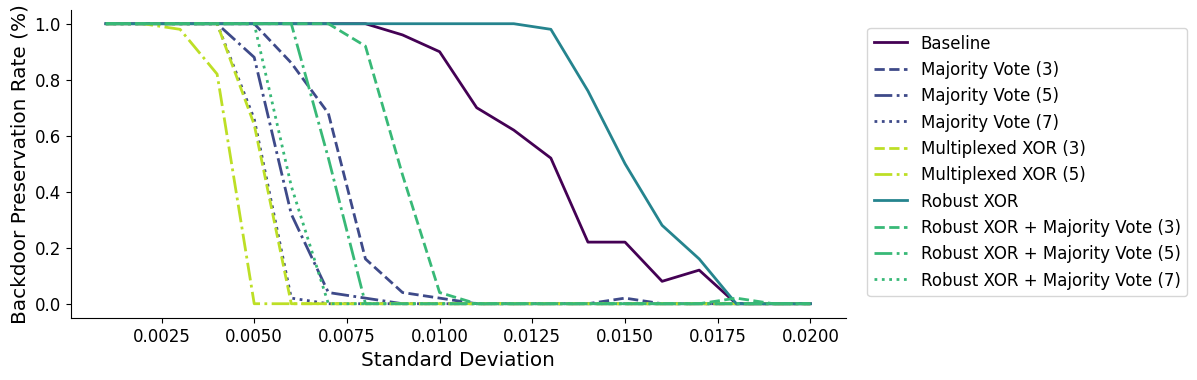

In [62]:
f = plot_success_rates(processed_success_df)
f.savefig(f"{base}/success_rate/success_rate.pdf", bbox_inches="tight")
f.savefig(f"{base}/success_rate/success_rate.png", bbox_inches="tight")

In [63]:
def preprocess_heatmap(df):
    layers = df["layer_idx"].unique()
    stds = df["std"].unique()[1:]
    mean_mae_per_std_layer = []
    mean_ber_per_std_layer = []

    for layer in layers:
        r_mae = []
        r_ber = []
        for std in stds:
            mean_mae = df[df["layer_idx"] == layer][df["std"] == std]["pre_mae"].mean()
            mean_ber = df[df["layer_idx"] == layer][df["std"] == std]["post_ber"].mean()
            assert not(np.isnan(mean_mae)), f"NaN value for layer {layer} and std {std}\n{df[df["layer_idx"] == layer][df["std"] == std]["pre_mae"].to_list()}"
            r_mae.append(mean_mae)
            r_ber.append(mean_ber)
        mean_mae_per_std_layer.append(r_mae)
        mean_ber_per_std_layer.append(r_ber)
    
    return mean_mae_per_std_layer, mean_ber_per_std_layer, layers, stds

In [18]:
def compute_errors(group):
    result = group.copy()
    # group["mean_mae"] = group["pre_mae"].mean()
    # group["mean_ber"] = group["post_ber"].mean()
    return group["pre_mae"].mean(), group["post_ber"].mean()

In [64]:
means = activation_errors.groupby(["model", "layer_idx", "std"])[["pre_mae", "post_ber"]].mean()

In [65]:
models = means.index.get_level_values("model").unique()
test = means.loc[models[0]]

In [66]:
test.index.get_level_values("layer_idx").unique()

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64', name='layer_idx')

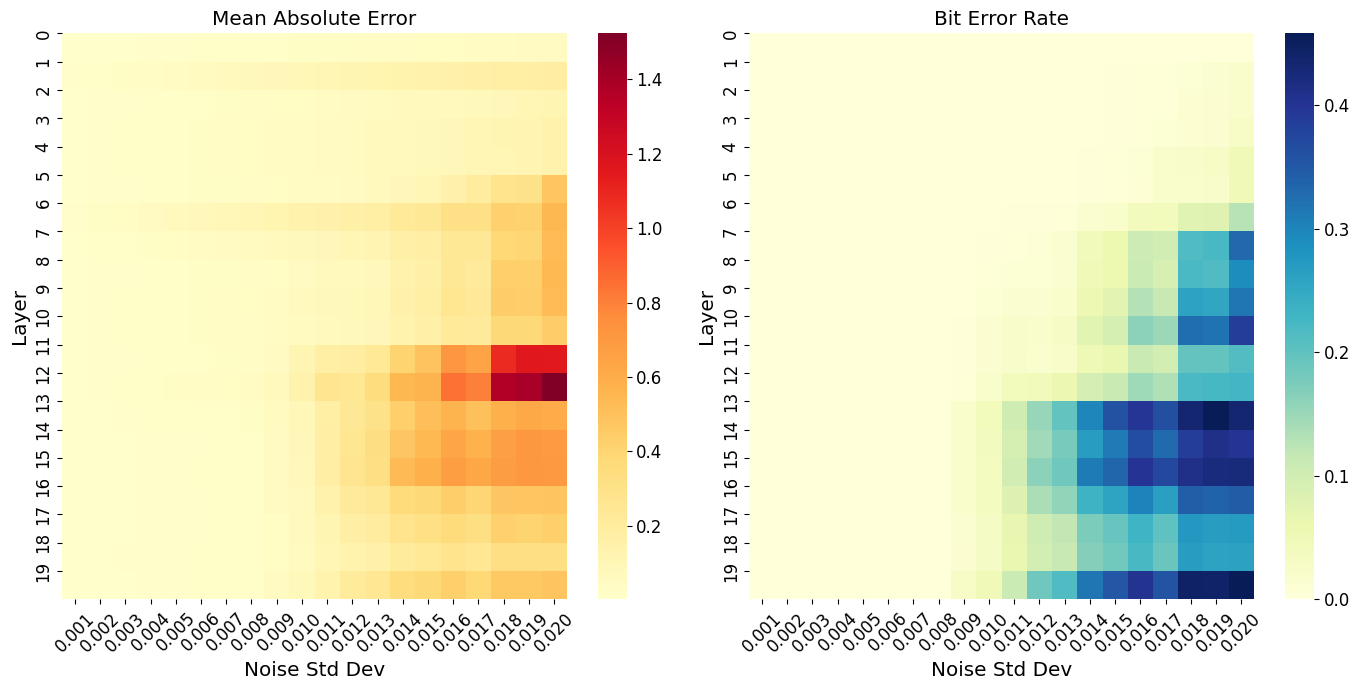

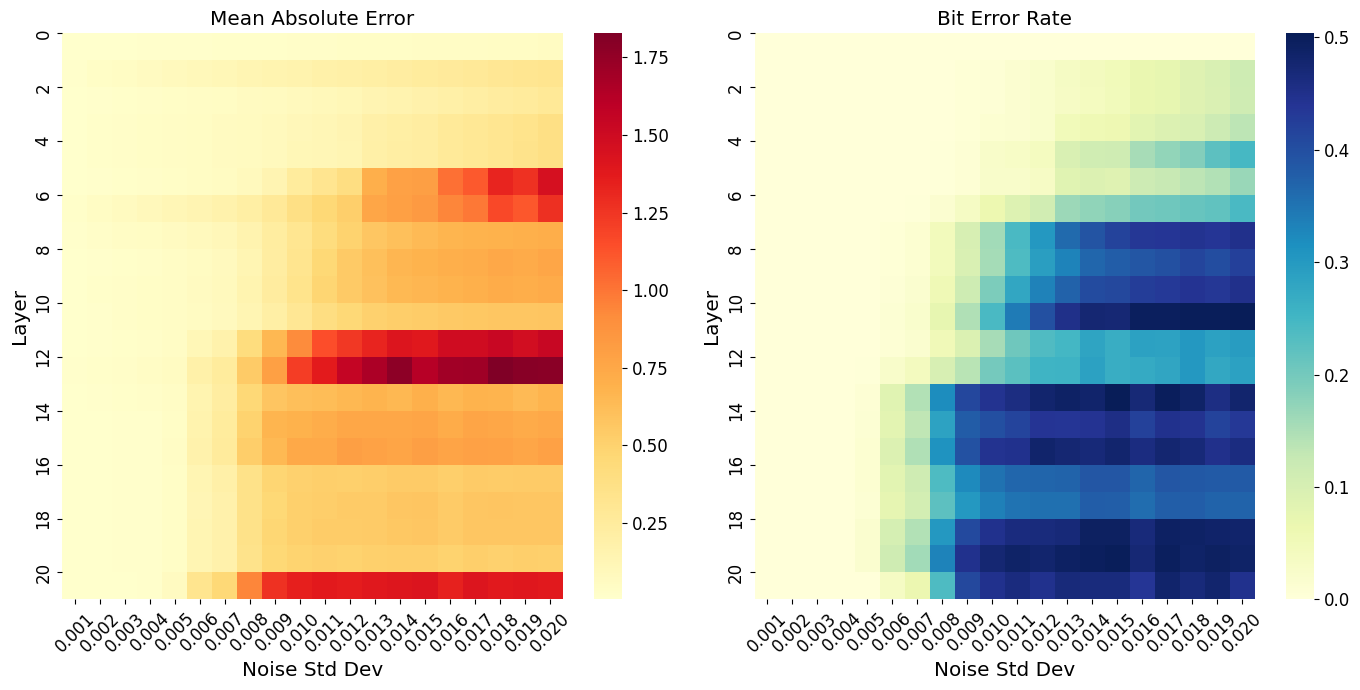

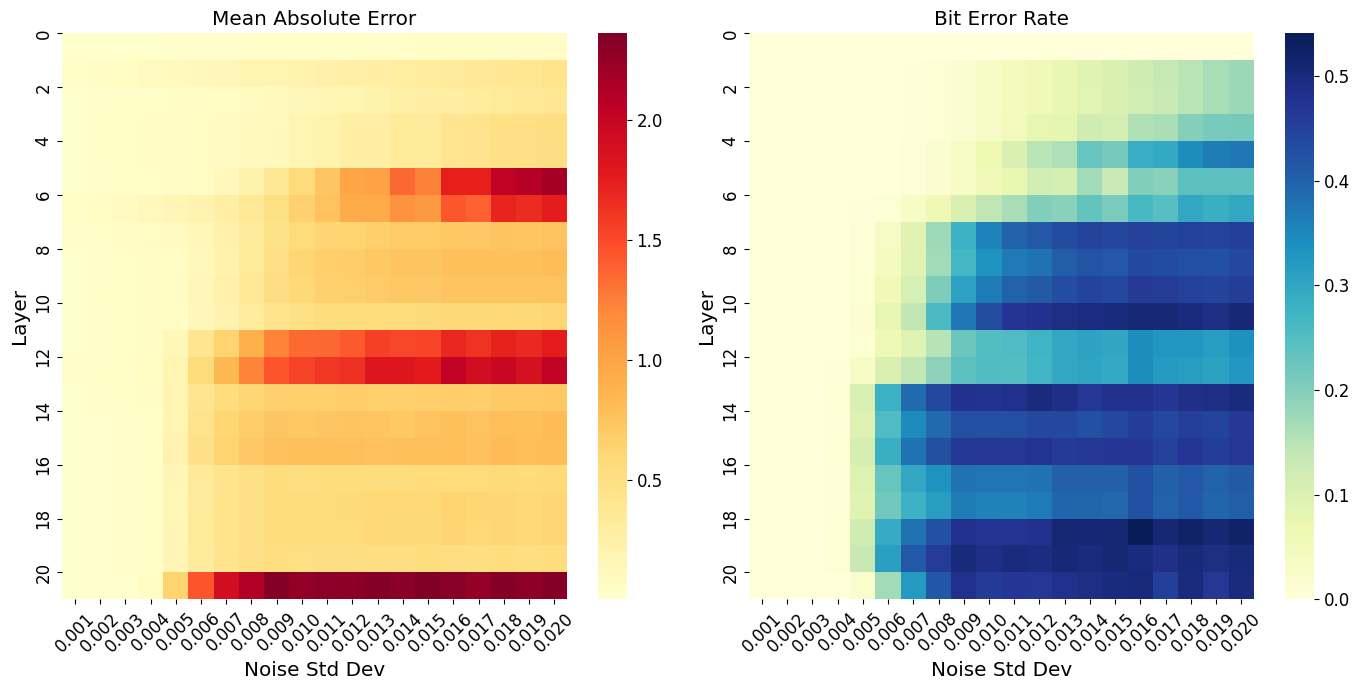

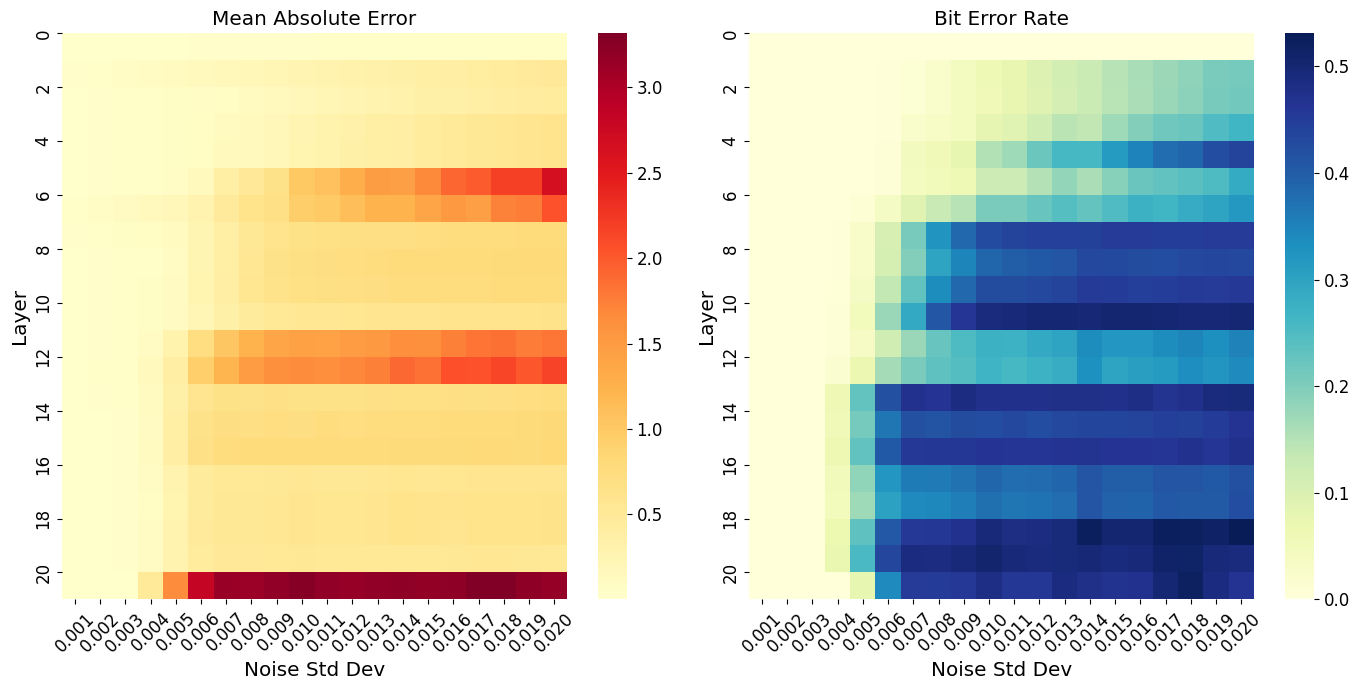

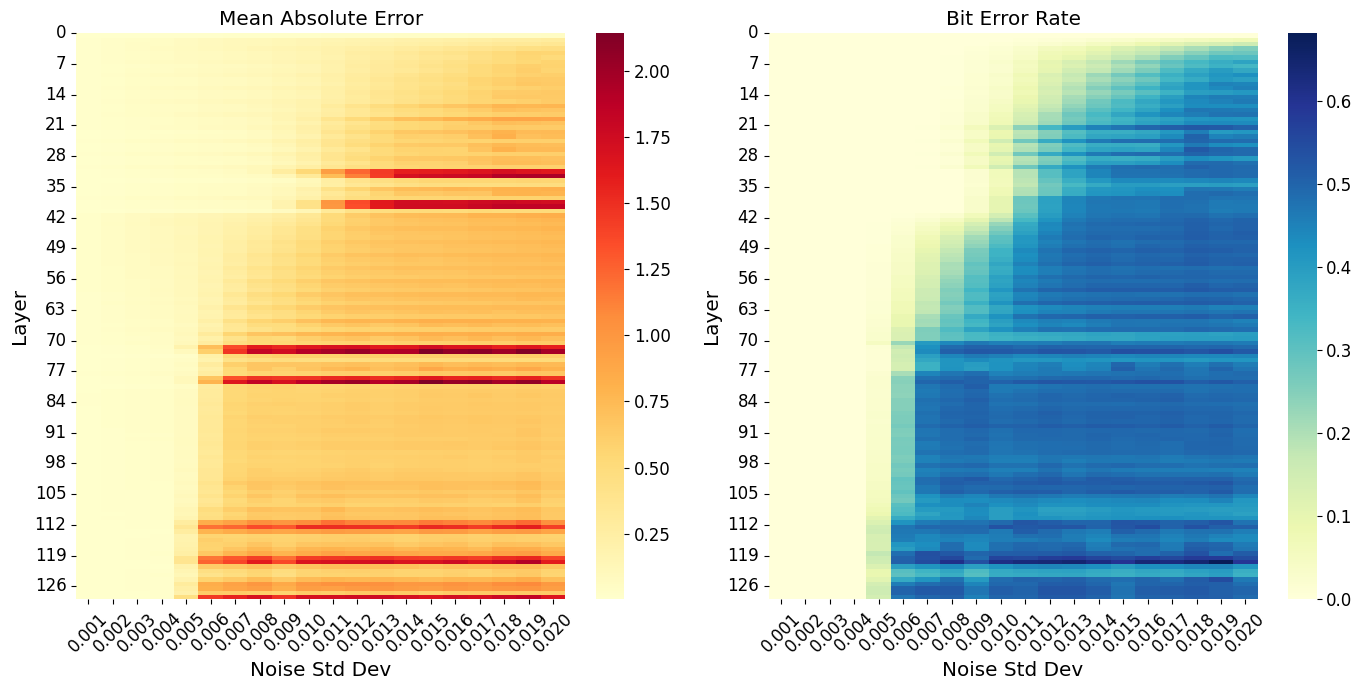

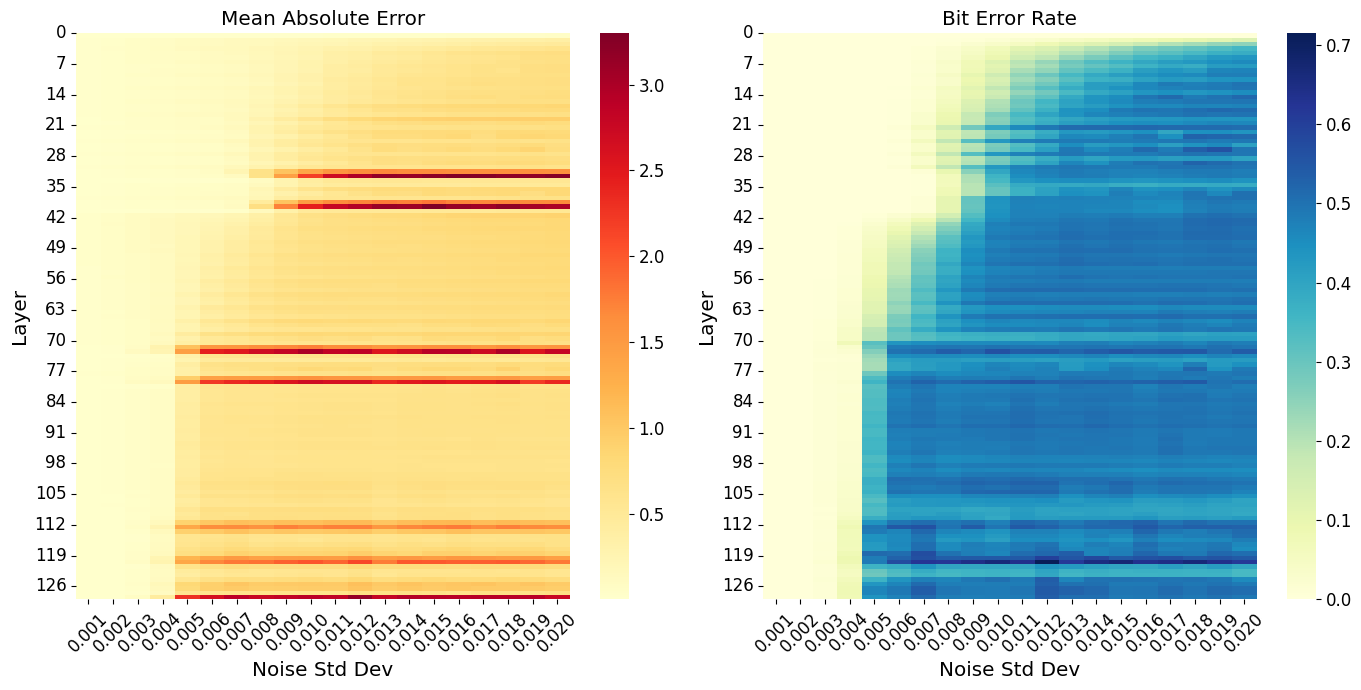

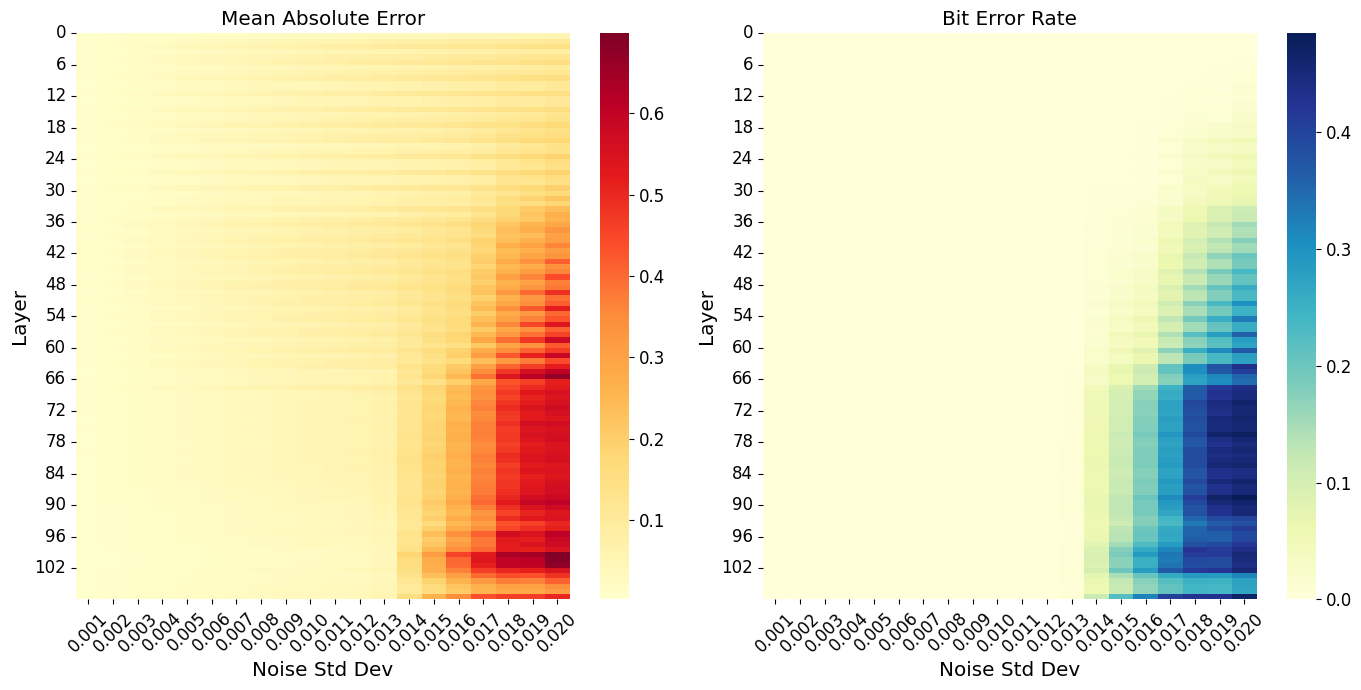

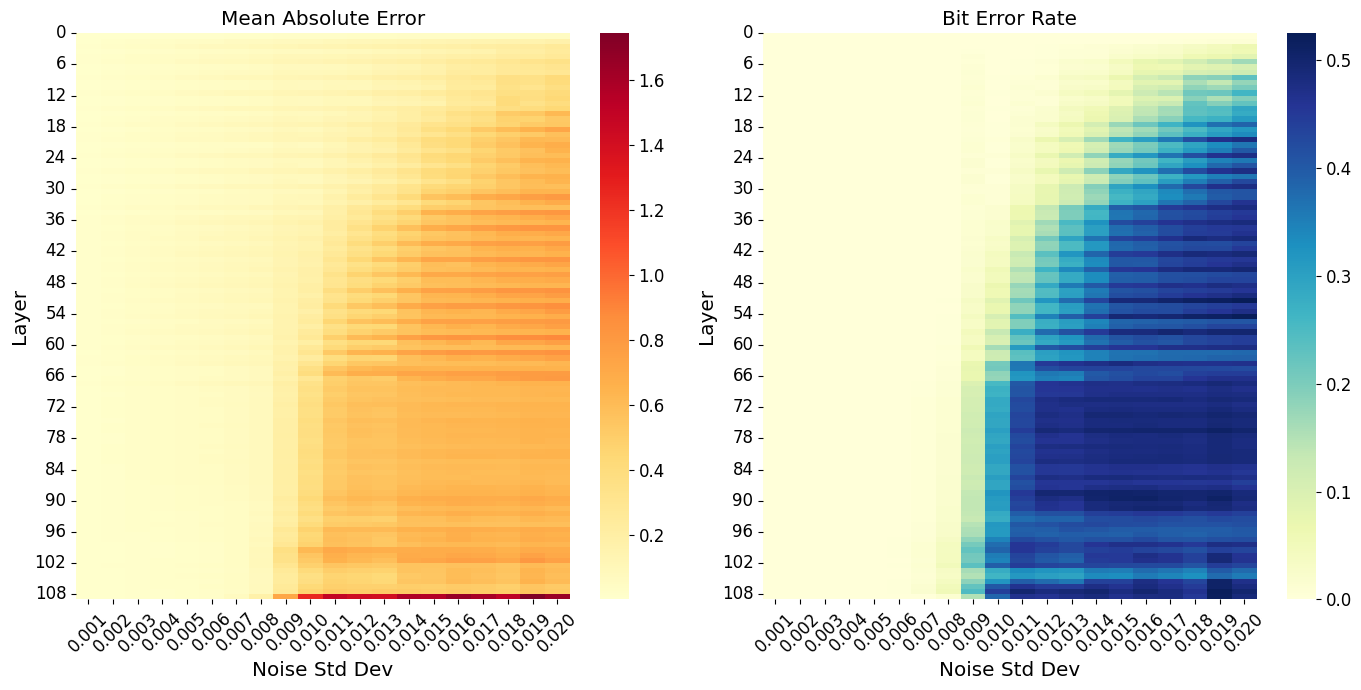

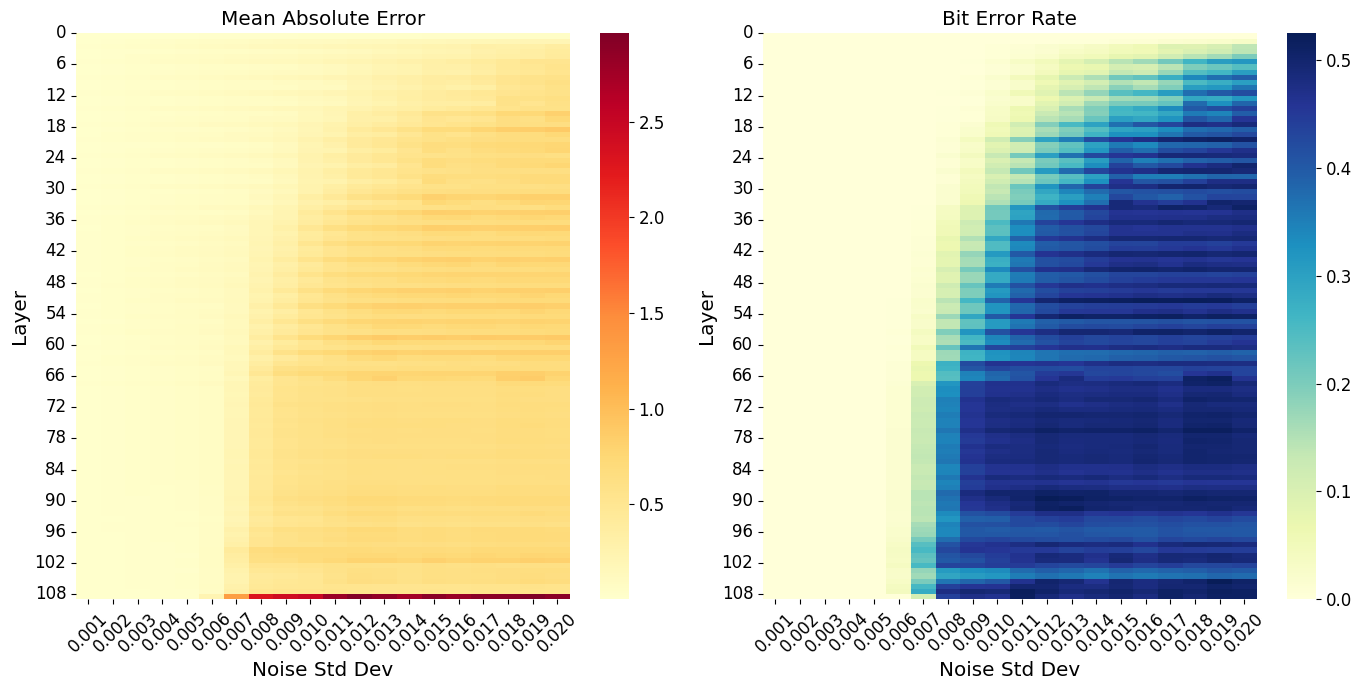

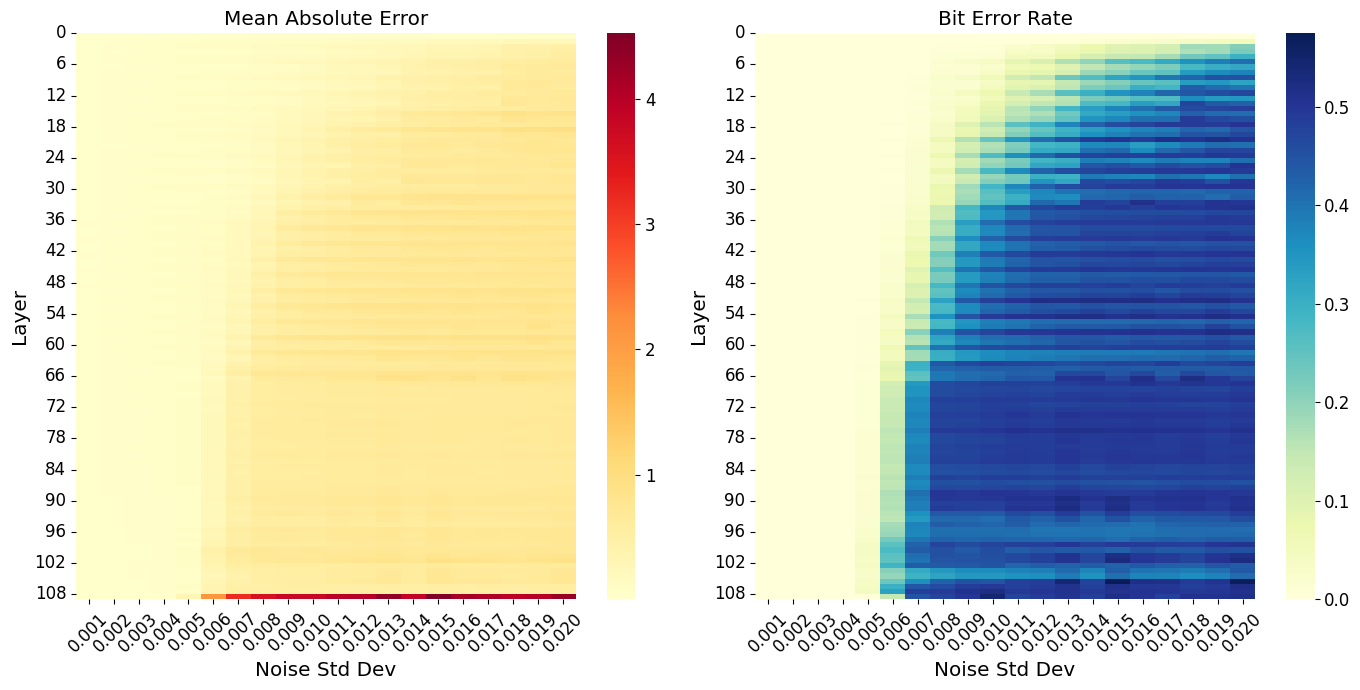

In [67]:
models = means.index.get_level_values("model").unique()
for model in models:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))

    model_data = means.loc[model]

    mae_pivot = model_data['pre_mae'].unstack('std')
    ber_pivot = model_data['post_ber'].unstack('std')
    mae_pivot.columns = [f'{col:.3f}' for col in mae_pivot.columns]
    ber_pivot.columns = [f'{col:.3f}' for col in ber_pivot.columns]

    layers : pd.Index = model_data.index.get_level_values("layer_idx").unique()
    stds : pd.Index = model_data.index.get_level_values("std").unique()
    y_tick_label_step = math.ceil(layers.size / stds.size)
    y_tick_labels = np.arange(stop=layers.size, step=y_tick_label_step)
    
    # MAE heatmap
    sns.heatmap(mae_pivot, ax=ax1, cmap='YlOrRd')
    cbar1 = ax1.collections[0].colorbar
    cbar1.ax.tick_params(labelsize='large')
    ax1.set_title(f'Mean Absolute Error', fontdict={'fontsize': 'x-large'})
    ax1.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax1.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax1.tick_params(axis='x', labelrotation=45)
    
    ax1.set_yticks(y_tick_labels)
    ax1.set_yticklabels(y_tick_labels)
    ax1.tick_params(axis='both', labelsize='large')
    
    # BER heatmap
    sns.heatmap(ber_pivot, ax=ax2, cmap='YlGnBu')
    cbar2 = ax2.collections[0].colorbar
    cbar2.ax.tick_params(labelsize='large')
    ax2.set_title(f'Bit Error Rate', fontdict={'fontsize': 'x-large'})
    ax2.set_xlabel('Noise Std Dev', fontdict={'fontsize': 'x-large'})
    ax2.set_ylabel('Layer', fontdict={'fontsize': 'x-large'})
    ax2.tick_params(axis='x', labelrotation=45)
    
    ax2.set_yticks(y_tick_labels)
    ax2.set_yticklabels(y_tick_labels)
    ax2.tick_params(axis='both', labelsize='large')
    
    plt.tight_layout()

    save_file = f"{base}/heatmaps/{model}"

    fig.savefig(f"{save_file}.pdf", bbox_inches="tight")
    fig.savefig(f"{save_file}.png", bbox_inches='tight')

In [18]:
def plot_error_per_layer(layers, stds, mae, ber):
    fig, ax = plt.subplots(4,5, figsize=(30,20))

    r_mae = 0
    c = 0
    for i, std in enumerate(stds):
        
        ax[r_mae, c].plot(layers,mae[:,i], label=f"Pre-Activation MAE")
        ax[r_mae, c].plot(layers, ber[:,i], label=f"Post-Activation BER")
        ax[r_mae, c].set_title(f"Std = {std:.3f}")
        c += 1
        if c > 4:
            r_mae += 1
            c = 0

    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, labels)

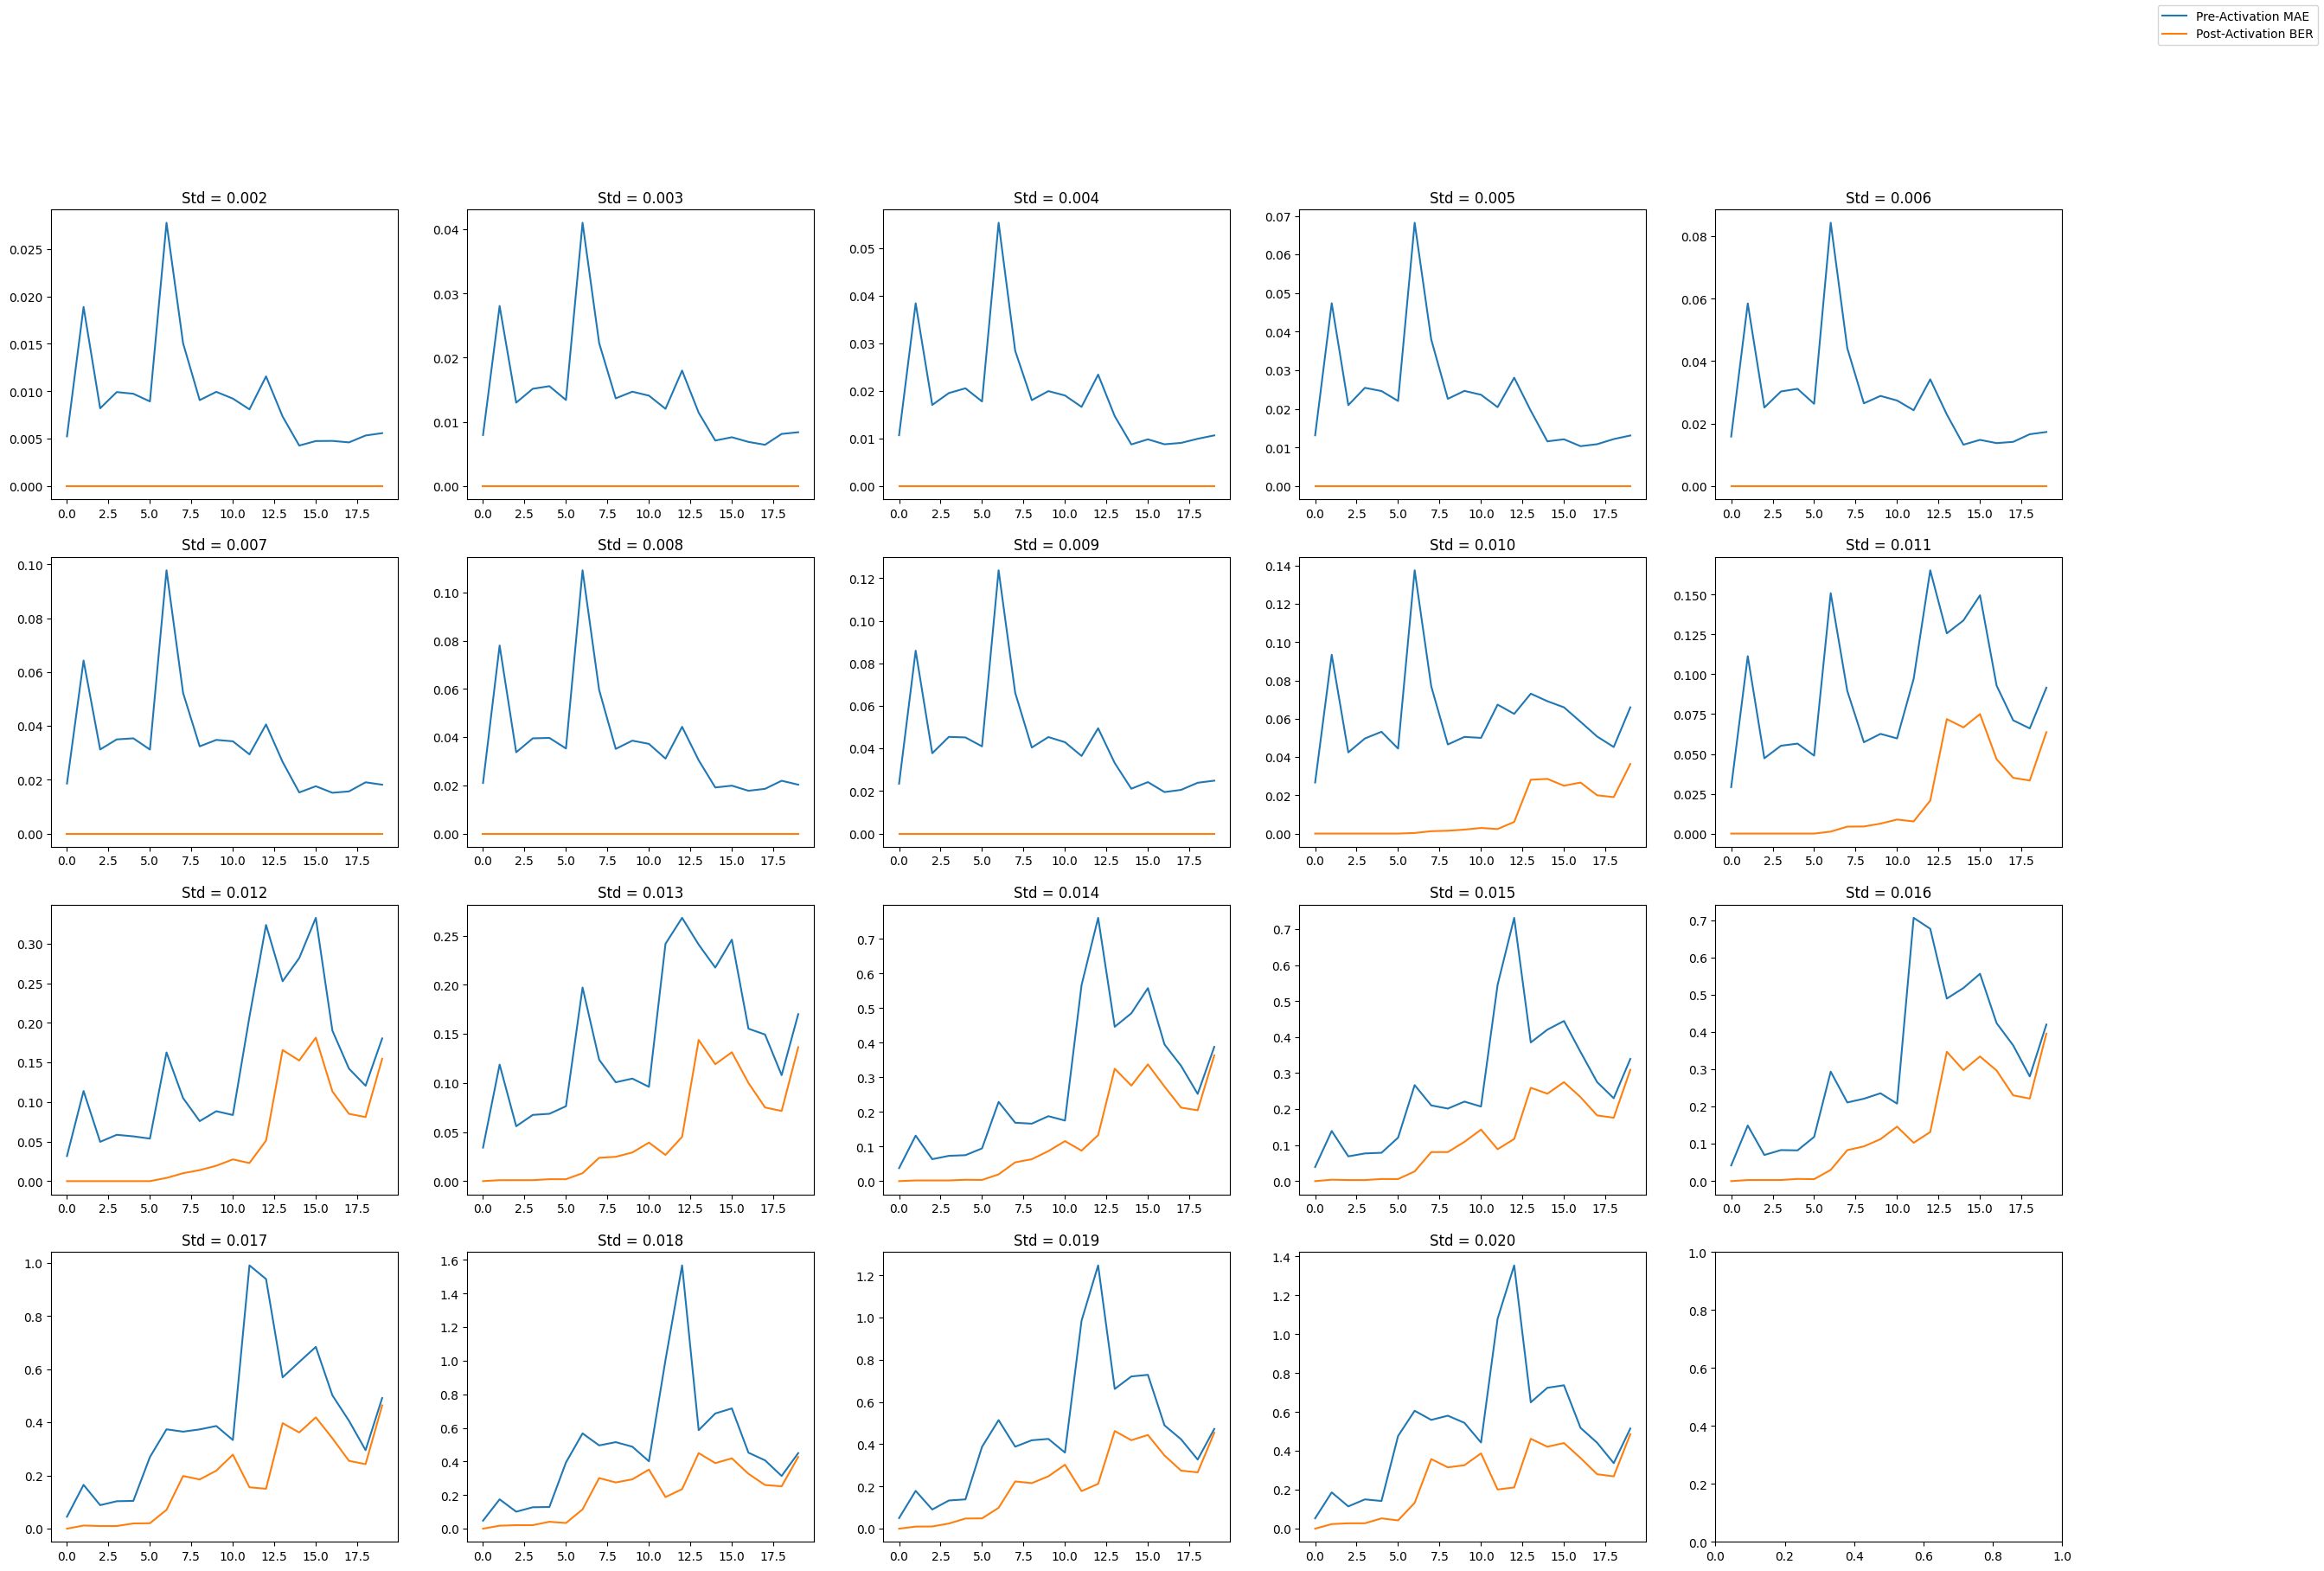

In [19]:
plot_error_per_layer(baseline_layers, baseline_stds, np.array(baseline_maes), np.array(baseline_bers))

# Evaluate inference times and model sizes

In [89]:
with open(f"{base}/model_comparison.json", "r") as f:
    data = json.loads(f.read())

In [93]:
data_unpacked = []
for model_name, model_data in data.items():
    results_unpacked = {
        "configuration": model_name,
        "redundancy": model_data["model_specs"]["redundancy"],
        "n_layers": model_data["results"]["layer_stats"]["n_layers"],
        "layer_n_params": model_data["results"]["layer_stats"]["layer_n_params"],
        "layer_widths": model_data["results"]["layer_stats"]["w_output"],
        "total_params": sum(model_data["results"]["layer_stats"]["layer_n_params"]),
        "max_layer_width": max(model_data["results"]["layer_stats"]["layer_n_params"]),
        "mean_inference_time": model_data["results"]["inference_time"]["mean_inference_time"]
    }
    data_unpacked.append(results_unpacked)

    
    

In [94]:
model_comparison_df = pd.DataFrame(data_unpacked)

In [96]:
model_comparison_df["mean_inference_time"] = model_comparison_df["mean_inference_time"].round(4)

In [98]:
print(model_comparison_df[["configuration", "n_layers", "total_params", "max_layer_width", "mean_inference_time"]].to_latex())

\begin{tabular}{llrrrr}
\toprule
 & configuration & n_layers & total_params & max_layer_width & mean_inference_time \\
\midrule
0 & baseline & 21 & 203940 & 74865 & 0.000500 \\
1 & robust_xor & 109 & 862486 & 21895 & 0.002200 \\
2 & baseline_majority_vote_3 & 22 & 1735226 & 670033 & 0.001300 \\
3 & baseline_majority_vote_5 & 22 & 4765858 & 1859121 & 0.003500 \\
4 & baseline_majority_vote_7 & 22 & 9295570 & 3642129 & 0.005300 \\
5 & robust_xor_majority_vote_3 & 110 & 7207739 & 195283 & 0.006800 \\
6 & robust_xor_majority_vote_5 & 110 & 19738759 & 541471 & 0.011900 \\
7 & robust_xor_majority_vote_7 & 110 & 38455123 & 1060459 & 0.017900 \\
8 & multiplexed_3 & 130 & 42670622 & 2725801 & 0.018900 \\
9 & multiplexed_5 & 130 & 118184646 & 7568001 & 0.039800 \\
\bottomrule
\end{tabular}

